In [134]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib, mplcursors
from scipy import signal, optimize, ndimage

%matplotlib inline

#matplotlib.use("pgf")


In [135]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'font.size': 12,
    'pgf.rcfonts': False,
     'axes.unicode_minus': False
})

In [136]:
def set_size(width, fraction=1, shape=(1,1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    if shape!=(1,1):
            golden_ratio = 1/2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    shape_ratio = shape[0] / shape[1]
    fig_height_in = fig_height_in * shape_ratio

    fig_dim = (fig_width_in , fig_height_in)

    return fig_dim


In [137]:
calibration_path = 'GMA Data/Spectrum Data/'
figures_path = '../tex/61b131aa6c2c24ed40fb5c29/figures/'

In [138]:
crystals = ['BGO', 'CSI', 'LYSO']
sources = ['Am-241', 'Cs-137', 'Na-22', 'Co-60 RO15', 'Co-60 LE859',]
BGO_dates = ['30-07-21', '30-07-21', '30-07-21', '30-07-21',]
CSI_dates = ['29-07-21', '29-07-21', '30-07-21', '29-07-21']
LYSO_dates = ['28-07-21', '28-07-21', '29-07-21', '28-07-21', '28-07-21']
crystals_dates = [BGO_dates, CSI_dates, LYSO_dates]

In [139]:
df = pd.DataFrame(columns=['crystal', 'date', 'source'])

for (crystal, dates) in zip(crystals, crystals_dates):
    for (source, date) in zip(sources, dates):
        source_low = source[0].lower() + source[1:]
        filename = 'en_res_' + crystal.lower() + '_' + source_low + ' ' + date + '.xlsx'
        path = calibration_path + crystal + '/' + filename
        try:
            df_temp = pd.read_excel(path)

            channel = df_temp['ADC Channel - Charge distribution']
            counts = df_temp['Counts - Charge distribution']
    
            channel.name = 'channel'
            counts.name = 'counts'
    
            df_to_append = pd.concat([channel, counts], axis=1)
            df_to_append['crystal'] = crystal
            df_to_append['date'] = date
            df_to_append['source'] = source
            
            df = df.append(df_to_append, ignore_index=True)
        except(FileNotFoundError):
            pass

In [140]:
def plot(dataframe, crystals, sources, ylabel):
    fig = plt.figure(figsize=(24,8))
    axs = fig.subplots(1,3)
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple']
    
    for (ax, crystal) in zip(axs, crystals):
        df_crystal = dataframe[df.crystal == crystal]
        for (color, source) in zip(colors, sources):
            if source in list(df_crystal['source']):
                df_source = df_crystal[df_crystal.source == source]
        
                counts = df_source[ylabel].to_numpy()
                channel = df_source.channel.to_numpy()
        
                ax.plot(channel, counts, label=crystal + ' ' + source, color=color, linewidth=0.5)         
    
        ax.set_xlabel('Channel')
        ax.set_ylabel('Counts')
        ax.legend()
        ax.grid(True)
        ax.set_yscale('linear')
        ax.set_xscale('linear')

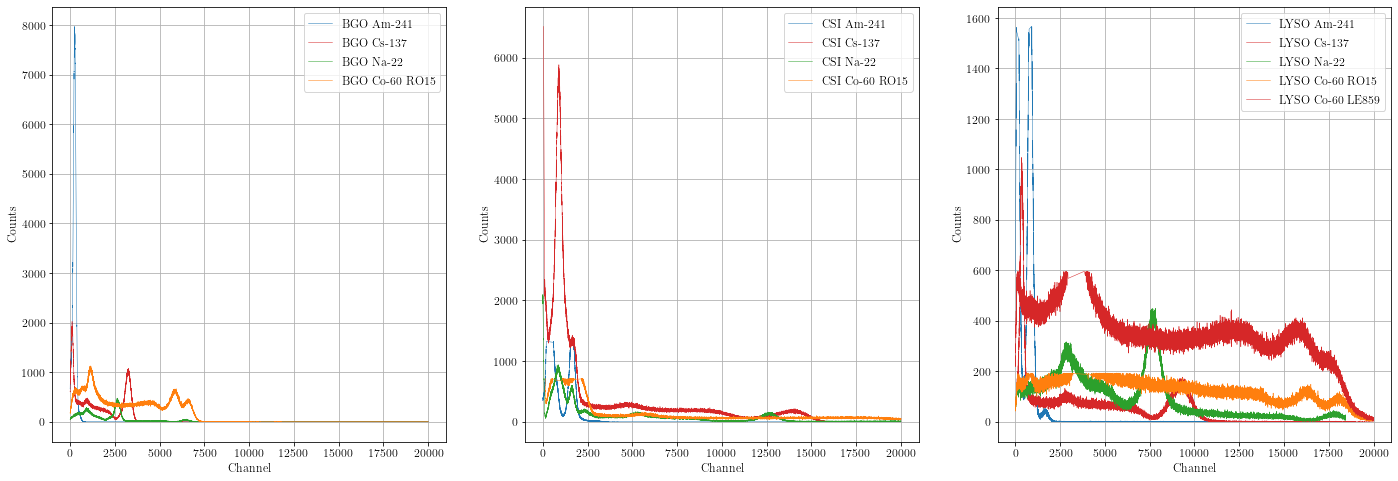

In [141]:
plot(df, crystals, sources, 'counts')

In [142]:
def smooth(dataframe, N=20):
    new_dataframe = pd.DataFrame()
    for crystal in dataframe.crystal.unique():
        df_crystal = dataframe[dataframe.crystal == crystal]
        for source in df_crystal.source.unique():
            df_source = df_crystal[df_crystal.source == source].copy()
            counts = df_source.counts
            counts = ndimage.uniform_filter(counts, N)
            df_source.loc[:, 'smooth'] = counts
            new_dataframe = new_dataframe.append(df_source)
    return new_dataframe.reset_index()
            

In [143]:
df_smooth = smooth(df)
df_smooth

,index,crystal,date,source,channel,counts,smooth
0,0,BGO,30-07-21,Am-241,0.5,662.0,728.80
1,1,BGO,30-07-21,Am-241,1.5,661.0,729.70
2,2,BGO,30-07-21,Am-241,2.5,737.0,731.75
3,3,BGO,30-07-21,Am-241,3.5,714.0,733.35
4,4,BGO,30-07-21,Am-241,4.5,723.0,737.95
...,...,...,...,...,...,...,...
249406,249406,LYSO,28-07-21,Co-60 LE859,19995.5,11.0,10.55
249407,249407,LYSO,28-07-21,Co-60 LE859,19996.5,11.0,10.60
249408,249408,LYSO,28-07-21,Co-60 LE859,19997.5,8.0,10.80
249409,249409,LYSO,28-07-21,Co-60 LE859,19998.5,10.0,11.15


In [144]:
peak_limits = [
    [
        [],
        [],
        [],
        []
    ],
    [
        [(200, 600), (1550, 1737)],
        [],
        [],
        [(530, 2200)],
    ],
    [
        [(46, 190), (767, 900)],
        [],
        [],
        [],
        [(2880, 3920)],
        []

    ]]

In [145]:
def find_peak(counts, channel, peak_limits, source, crystal, N=None, plot=False):
    if N is None:
        if source == 'Am-241':
            N = 40
        elif source[:5] == 'Co-60':
            N = 150
        else:
            N = 50
    
    peak_left=peak_limits[0]
    peak_right=peak_limits[1]
    
    i_peak_left = np.argmin(np.abs(peak_left - channel))
    i_peak_right = np.argmin(np.abs(peak_right - channel))
    
    def linear(x, m, q):
        return m*x + q
        
    x_left = channel[i_peak_left - N:i_peak_left]
    x_right = channel[i_peak_right:i_peak_right + N]
    y_left = counts[i_peak_left - N:i_peak_left]
    y_right = counts[i_peak_right:i_peak_right + N]
    
    (m_left, q_left), _ = optimize.curve_fit(linear, x_left, y_left, p0=(1, counts[i_peak_left]))
    (m_right, q_right), _ = optimize.curve_fit(linear, x_right, y_right, p0=(1, counts[i_peak_right]))
    
    x_peak = (q_left - q_right) / (m_right - m_left)
    y_peak = linear(x_peak, m_left, q_left)
    
    x_left = np.linspace(peak_left-N, x_peak, 1000)
    x_right = np.linspace(x_peak, peak_right+N, 1000)
    y_left = linear(x_left, m_left, q_left)
    y_right = linear(x_right, m_right, q_right)
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(channel, counts)    
        ax.plot(np.append(x_left, x_right), np.append(y_left, y_right), linestyle='', marker='.')
    
    return ([x_left, y_left, x_right, y_right], x_peak, y_peak, (i_peak_left - N, i_peak_right + N))   

In [146]:
df_peaks = pd.DataFrame(columns=['Crystal', 'Source', 'Channel_peak', 'Peak_height', 'Peak_width'], dtype=object)
df_smooth_peaks = pd.DataFrame()
for (crystal, peak_limits_crystal) in zip(crystals, peak_limits):
    df_crystal = df_smooth[df_smooth.crystal == crystal]
    crystal_channel_peaks = []
    df_crystal_new = pd.DataFrame()
    for (source, peak_limits_source) in zip(sources, peak_limits_crystal):
        df_source = df_crystal[df_crystal.source == source].copy()

        counts = df_source.smooth.to_numpy()
        channel = df_source.channel.to_numpy()

        channel_peaks = []
        peaks_height = []
        peaks_index = []

        for peak_lim in peak_limits_source:
            coordinates, x_peak, y_peak, limits = find_peak(counts, channel, peak_lim, source, crystal)
            channel = np.concatenate([channel[:limits[0]], coordinates[0], coordinates[2], channel[limits[1]:]])
            counts = np.concatenate([counts[:limits[0]], coordinates[1], coordinates[3], counts[limits[1]:]])

        data = np.array([channel, counts])
        df_source_new = pd.DataFrame(data.T, columns=['channel', 'counts'])
        df_source_new['crystal'] = crystal
        df_source_new['source'] = source
        
        peaks, properties = signal.find_peaks(counts, prominence=(80, None), width=(None, None)) 
        channel_peaks = channel[peaks]
        peaks_height = counts[peaks]
        half_widths = properties['widths']
        half_heights = properties['width_heights']
        half_lefts = channel[properties['left_ips'].astype('int')]
        half_rights = channel[properties['right_ips'].astype('int')]
        
        for (x_peak, y_peak, width) in zip(channel_peaks, peaks_height, half_widths):
            df_peaks = df_peaks.append({'Crystal': crystal, 'Source': source, 'Channel_peak':x_peak, 'Peak_height':y_peak, 'Peak_width':width}, ignore_index=True)
        df_crystal_new = df_crystal_new.append(df_source_new)
    df_smooth_peaks = df_smooth_peaks.append(df_crystal_new)

In [147]:
df_peaks

,Crystal,Source,Channel_peak,Peak_height,Peak_width
0,BGO,Am-241,251.500000,7800.650000,161.228104
1,BGO,Cs-137,110.500000,1904.350000,136.163817
2,BGO,Cs-137,956.500000,427.500000,246.211890
3,BGO,Cs-137,3250.500000,1020.000000,383.264525
4,BGO,Na-22,921.500000,254.450000,855.002198
5,BGO,Na-22,2655.500000,421.200000,346.084375
6,BGO,Co-60 RO15,1114.500000,1075.550000,852.348325
7,BGO,Co-60 RO15,5845.500000,627.750000,485.891176
8,BGO,Co-60 RO15,6598.500000,432.150000,267.400000
9,CSI,Am-241,341.692564,2952.518112,1313.571959


In [148]:
df_peaks_dropped = df_peaks.drop([4, 13, 14, 21, 23, 24])

In [149]:
df_peaks_dropped

,Crystal,Source,Channel_peak,Peak_height,Peak_width
0,BGO,Am-241,251.500000,7800.650000,161.228104
1,BGO,Cs-137,110.500000,1904.350000,136.163817
2,BGO,Cs-137,956.500000,427.500000,246.211890
3,BGO,Cs-137,3250.500000,1020.000000,383.264525
5,BGO,Na-22,2655.500000,421.200000,346.084375
6,BGO,Co-60 RO15,1114.500000,1075.550000,852.348325
7,BGO,Co-60 RO15,5845.500000,627.750000,485.891176
8,BGO,Co-60 RO15,6598.500000,432.150000,267.400000
9,CSI,Am-241,341.692564,2952.518112,1313.571959
10,CSI,Am-241,1649.311506,1829.452221,2022.787621


In [150]:
energy_peaks_BGO = [59.5412, 31.8, 283.5, 661.657, 511.006, 346.93, 1332, 1173,]
energy_peaks_CSI = [26.3448, 59.5412, 31.8000, 661.6570, 511.0060, 58.603,]
energy_peaks_LYSO = [26.3448, 59.5412, 31.8000, 661.6570, 511.0060, 346.93, 1173.0000]
energy_peaks =  energy_peaks_BGO + energy_peaks_CSI + energy_peaks_LYSO
df_peaks_dropped['Energy_peak'] = energy_peaks
df_peaks_dropped['ER'] = df_peaks_dropped.Peak_width / df_peaks_dropped.Peak_height
df_peaks_dropped

,Crystal,Source,Channel_peak,Peak_height,Peak_width,Energy_peak,ER
0,BGO,Am-241,251.500000,7800.650000,161.228104,59.5412,0.020669
1,BGO,Cs-137,110.500000,1904.350000,136.163817,31.8000,0.071501
2,BGO,Cs-137,956.500000,427.500000,246.211890,283.5000,0.575934
3,BGO,Cs-137,3250.500000,1020.000000,383.264525,661.6570,0.375750
5,BGO,Na-22,2655.500000,421.200000,346.084375,511.0060,0.821663
6,BGO,Co-60 RO15,1114.500000,1075.550000,852.348325,346.9300,0.792477
7,BGO,Co-60 RO15,5845.500000,627.750000,485.891176,1332.0000,0.774020
8,BGO,Co-60 RO15,6598.500000,432.150000,267.400000,1173.0000,0.618767
9,CSI,Am-241,341.692564,2952.518112,1313.571959,26.3448,0.444899
10,CSI,Am-241,1649.311506,1829.452221,2022.787621,59.5412,1.105679


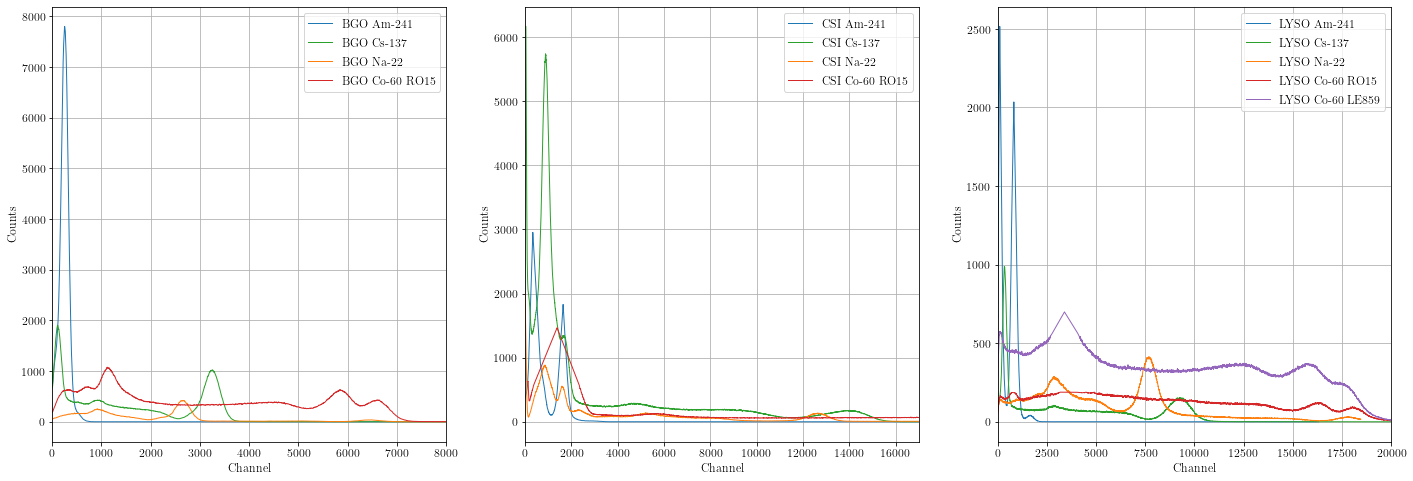

In [156]:
fig = plt.figure(figsize=(24,8))
axs = fig.subplots(1,3)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple']
axs_lims = [(0, 8000), (0, 17000), (0, 20000)]

for (ax, ax_lims, crystal, peak_limits_crystal) in zip(axs, axs_lims, crystals, peak_limits):
    df_crystal = df_smooth_peaks[df_smooth_peaks.crystal == crystal]
    df_peaks_crystal = df_peaks_dropped[df_peaks_dropped.Crystal == crystal]
    for (color, source, peak_limits_source) in zip(colors, sources, peak_limits_crystal):
        df_source = df_crystal[df_crystal.source == source]

        counts = df_source.counts.to_numpy()
        channel = df_source.channel.to_numpy()

        ax.plot(channel, counts, label=crystal + ' ' + source, color=color, linewidth=1)

    

    ax.set_xlabel('Channel')
    ax.set_ylabel('Counts')
    ax.legend()
    ax.grid(True)
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_xlim(ax_lims)

0.20203213633287337 +/- 0.010286098423522298
0.044070767392403724 +/- 0.001560309174937215
0.07343346725919883 +/- 0.0023158504059249433


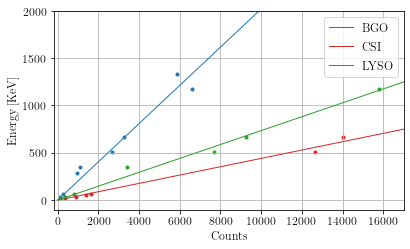

In [152]:
fig = plt.figure(figsize=set_size(424, fraction=1))
#axs = fig.subplots(1,3)
ax = fig.add_subplot()
ax.grid(True)
colors = ['tab:blue', 'tab:red', 'tab:green']

def linear(x, m):
    return m*x
calibration_factors = []

for (crystal, color) in zip(crystals, colors):
    df_cal = df_peaks_dropped[(df_peaks_dropped.Crystal == crystal)]
    channels = df_cal.Channel_peak.to_numpy()
    energies = df_cal.Energy_peak.to_numpy()
    par, cov = optimize.curve_fit(linear, channels, energies, p0=(1/100))
    x = np.linspace(0, 17000, 1000)
    y = linear(x, par[0])
    
    ax.scatter(channels, energies, marker='.', color=color)
    ax.plot(x, y, linewidth=1, color=color, label=crystal)

    print(par[0], '+/-', np.sqrt(np.diag(cov))[0])
    calibration_factors.append(par[0])

ax.set_xlabel('Counts')
ax.set_ylabel('Energy [KeV]')
ax.grid(True)
ax.legend()
ax.set_xlim(-200, 17000)
ax.set_ylim(-100, 2000)
    
fig.tight_layout()
fig.savefig(figures_path + 'calibration.pdf')

0.00014286581311592458 +/- 3.253848732380772e-05
0.0006331839468435509 +/- 1.1087679128383401e-05
0.00038732881635505315 +/- 0.00012063185283592551


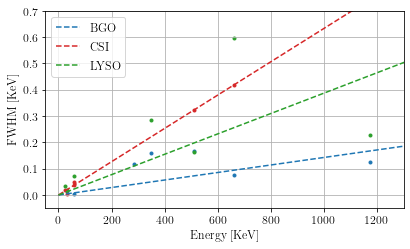

In [153]:
fig = plt.figure(figsize = set_size(424, fraction=1))
ax = fig.add_subplot()
colors = ['tab:blue', 'tab:red', 'tab:green']

def linear(x, m):
    return x*m

for (color, crystal, calibration_factor) in zip (colors, crystals, calibration_factors):
    energy = df_peaks_dropped[df_peaks_dropped.Crystal == crystal].Energy_peak.to_numpy()
    ER = df_peaks_dropped[df_peaks_dropped.Crystal == crystal].ER.to_numpy() * calibration_factor
    ax.scatter(energy, ER, color=color, marker='.')
    par, cov = optimize.curve_fit(linear, energy, ER)
    xs = np.linspace(0, 2000, 1000)
    ax.plot(xs, linear(xs, par[0]), color=color, linestyle='--', label=crystal)

    print(par[0], '+/-', np.sqrt(cov[0,0]))
ax.grid(True)
ax.legend()
ax.set_xlabel('Energy [KeV]')
ax.set_ylabel('FWHM [KeV]')
ax.set_xlim(-50, 1300)
ax.set_ylim(-0.05, 0.7)

fig.tight_layout()
fig.savefig(figures_path + 'resolution.pdf')

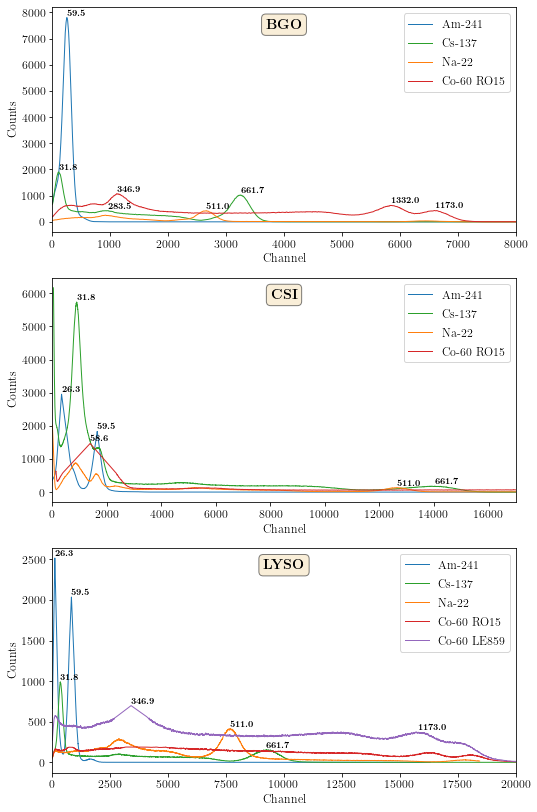

In [159]:
fig = plt.figure(figsize=set_size(424, fraction=1.3, shape=(3,1)))
axs = fig.subplots(3,1)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple']
axs_lims = [(0, 8000), (0, 17000), (0, 20000)]

df_peaks = pd.DataFrame(columns=['Crystal', 'Source', 'Channel_peak', 'Peak_height', 'Peak_width'], dtype=object)

for (ax, ax_lims, crystal, peak_limits_crystal, calibration_factor) in zip(axs, axs_lims, crystals, peak_limits, calibration_factors):

    df_crystal = df_smooth[df_smooth.crystal == crystal]
    df_peaks_crystal = df_peaks_dropped[df_peaks_dropped.Crystal == crystal]
    crystal_channel_peaks = []
    for (color, source, peak_limits_source) in zip(colors, sources, peak_limits_crystal):
        df_source = df_crystal[df_crystal.source == source].copy()

        counts = df_source.smooth.to_numpy()
        channel = df_source.channel.to_numpy()

        for peak_lim in peak_limits_source:
            coordinates, x_peak, y_peak, limits = find_peak(counts, channel, peak_lim, source, crystal)
            channel = np.concatenate([channel[:limits[0]], coordinates[0], coordinates[2], channel[limits[1]:]])
            counts = np.concatenate([counts[:limits[0]], coordinates[1], coordinates[3], counts[limits[1]:]])
            
            #ax.plot(coordinates[0], coordinates[1], linestyle='--', color=color)
            #ax.plot(coordinates[2], coordinates[3], linestyle='--', color=color)
            channel_peaks = np.append(channel_peaks, x_peak)
            peaks_height = np.append(peaks_height, y_peak)
            peaks_index = np.append(peaks_index, np.argmin(np.abs(x_peak - channel)))

        ax.plot(channel, counts, label=source, color=color, linewidth=1)
        
        peaks, properties = signal.find_peaks(counts, prominence=(80, None), width=(None, None)) 
        channel_peaks = channel[peaks]
        peaks_height = counts[peaks]
        half_widths = properties['widths']
        half_heights = properties['width_heights']
        half_lefts = channel[properties['left_ips'].astype('int')]
        half_rights = channel[properties['right_ips'].astype('int')]
        
        for (x_peak, y_peak, width) in zip(channel_peaks, peaks_height, half_widths):
            df_peaks = df_peaks.append({'Crystal': crystal, 'Source': source, 'Channel_peak':x_peak, 'Peak_height':y_peak, 'Peak_width':width}, ignore_index=True)  

        #for (half_height, half_left, half_right) in zip(half_heights, half_lefts, half_rights):
         #   xs = np.linspace(half_left, half_right, 100)
         #   ys = np.ones(100) * half_height
         #   ax.plot(xs, ys, color=color)

    for (x, y, energy) in zip(df_peaks_crystal.Channel_peak, df_peaks_crystal.Peak_height, df_peaks_crystal.Energy_peak):
        ax.text(x, y, r'\small{\textbf{' + str(round(energy, 1)) + '}}', verticalalignment='bottom', horizontalalignment='left')#

    ax.set_xlabel('Channel')
    ax.set_ylabel('Counts')
    ax.legend()
    ax.grid(False)
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_xlim(ax_lims)
    fig.tight_layout()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title(r'\Large{\textbf{' + crystal + '}}', y=0.88, bbox=props)
fig.savefig(figures_path + 'spectra' + '.pdf')

#mplcursors.cursor(hover=True)

In [155]:
df_peaks_dropped

mean_energy_sources = []
for source in sources:
    df_source = df_peaks_dropped[df_peaks_dropped.Source == source]
    mean_energy_crystals = []
    for crystal in crystals:
        df_crystal = df_source[df_source.Crystal == crystal]
        mean_energy_crystal = (df_source['Energy_peak'] * df_source['Peak_height']).sum() / df_source['Peak_height'].sum()
        mean_energy_crystals.append(mean_energy_crystal)
    mean_energy_source = np.mean(mean_energy_crystals)
    mean_energy_sources.append(mean_energy_source)
print(mean_energy_sources)

[48.946452112049364, 123.96591809974102, 511.00600000000003, 500.3553267637389, 633.5146152792983]
